# Double Wishbone Design Notebook

In [1]:
# %% Imports
import os, sys 

import tomllib as toml

import matplotlib.pyplot as plt
%matplotlib widget

sys.path.insert(0, os.path.realpath('..'))
from suspension_designer.linkages.double_wishbone import DoubleWishbone

In [2]:
# %% Test TOML Input
testInput = """
[vehicle]
wheelbase   = 1525      # [mm]
"%f"        =   47      # [%]       (Front Weight Distribution)
cg_height   =  225      # [mm]
ride        =   50      # [mm]      (Ride Clearance Height)
rake        =   +1.00   # [deg] 
tire_radius =  200      # [mm]      (Loaded Tire Radius)

[target]
axle        = "front"   # []        (front (f), rear (r))
track       = 1220      # [mm] 
"%roll"     =  +80.00   # [%]       (Roll-Jacking Tradeoff)
"%pitch"    = +100.00   # [%]       (Pitch-Jacking Tradeoff)
caster      =   +3.00   # [deg]
caster_gain =   +0.00   # [deg/mm] 
camber      =   -1.60   # [deg]
camber_gain =   -0.008  # [deg/mm]
toe         =   +0.50   # [deg]
kpi         =   +5.00   # [deg]     (Recommended for Front Axles)
#scrub      =   +0.00   # [mm]      (Recommended for Rear Axles)

[bound]     # [mm]
LAF = [[   0   ,   0   ], [ 200.00, 221.00], [  12.50,  12.50]] # {X} 
LAR = [[   0   ,   0   ], [ 200.00, 221.00], [  12.50,  12.50]] # {X}
LB  = [[   0.00,   0.00], [ -25.00, -22.00], [ -80.00, -70.00]] # {W}

UAF = [[   0   ,   0   ], [   0   ,   0   ], [ 175.00, 200.00]] # {X}
UAR = [[   0   ,   0   ], [   0   ,   0   ], [ 175.00, 200.00]] # {X}
UB  = [[   0.00,   0.00], [ -50.00, -22.00], [  75.00, 100.00]] # {W}

TA  = [[  50.00,  75.00], [ 221.00, 221.00], [  50.00,  75.00]] # {X}
TB  = [[  60.00,  75.00], [   0   ,   0   ], [ -50.00,  50.00]] # {W}
"""

C:\Users\Authorized User\Documents\GitHub\suspension_designer\suspension_designer\linkages\double_wishbone.py:48: RuntimeWarning: divide by zero encountered in double_scalars
  self.target['SVSA'] = 1/np.tan(np.deg2rad(np.abs(self.target['caster_gain'])))
c:\Users\Authorized User\miniconda3\envs\suspdes\Lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:124: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


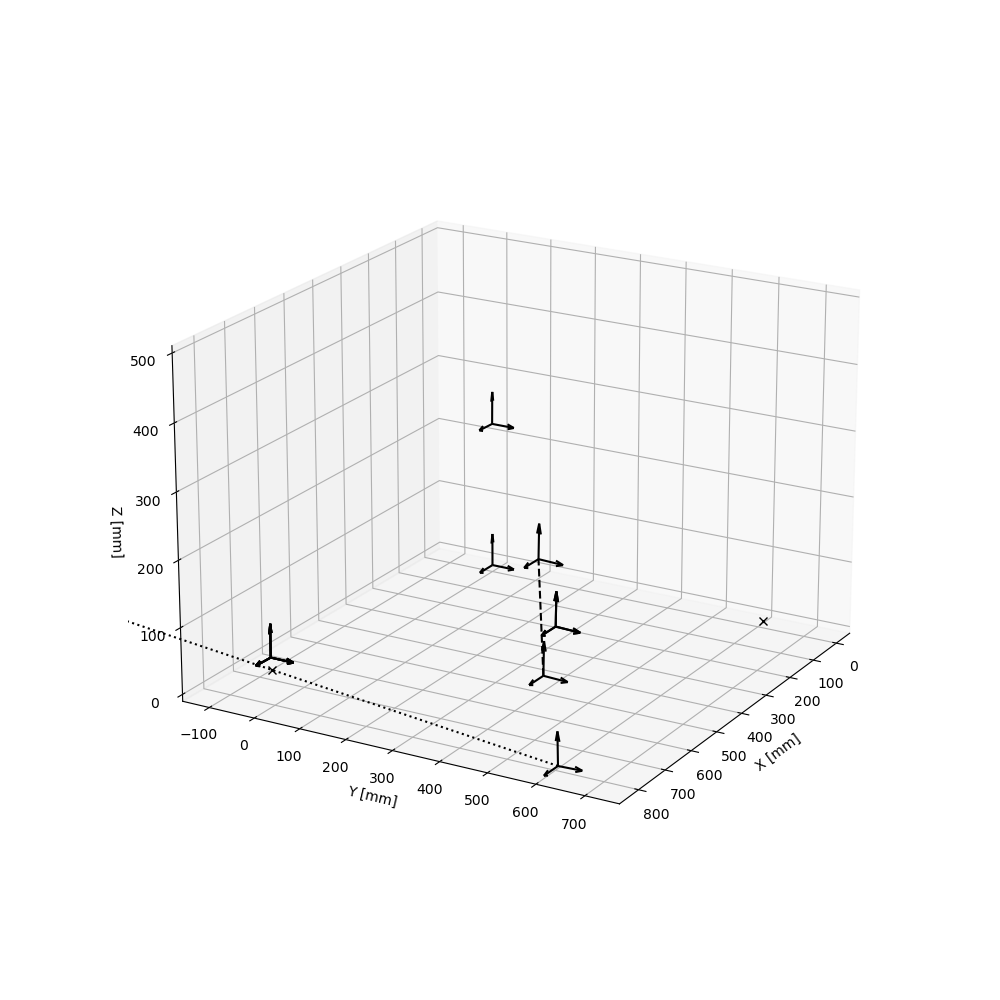

In [3]:
# %% Initialize
doubleWishbone = DoubleWishbone(toml.loads(testInput))

# Design
doubleWishbone.design()

_pause = 1